In [1]:
%matplotlib inline
import os
import pathlib

import numpy
import pandas

import psycopg2
import psycopg2.extras

from matplotlib import pyplot

psycopg2.extensions.register_adapter(numpy.int64, psycopg2.extensions.AsIs)

In [2]:
# Connect to the database
dbuserpass_path = pathlib.Path( os.getenv("HOME") ) / "secrets/decatdb_decat_decat_ro" 
if dbuserpass_path.is_file():
    with open( dbuserpass_path ) as ifp:
        dbuser, dbpasswd = ifp.readline().strip().split()
else:
    dbuser = 'decat_ro'
    dbpasswd = getpass.getpass( 'decat readonly database password: ' )
db = psycopg2.connect(dbname='decat', user=dbuser, password=dbpasswd, host='decatdb.lbl.gov',
                      cursor_factory=psycopg2.extras.RealDictCursor)

In [5]:
fields = { 'COSMOS-1': ( 150.0, 3.1 ),
           'COSMOS-2': ( 149.22, 1.75 ),
           'COSMOS-3': ( 150.78, 1.75 ),
           'ELAIS-E1': ( 7.8746, -43.0096 ),
           'ELAIS-E2': ( 9.5, -43.9980 ),
           'DECaPS-East': ( 270.89, -29.53 ),
           'DECaPS-West': ( 116.32, -26.25 )
         }
proposals = ( '2021A-0113', '2021B-0149', '2022A-724693', '2022B-762828', '2023A-726082' )
t0 = 59290
t1 = 60165
dt = 7
nbucks = ( t1 - t0 ) / dt
if ( nbucks - int(nbucks) ) != 0:
    raise ValueError( "Non-integral number of buckets." )
nbucks = int(nbucks)

dfs = {}

for field, radec in fields.items():
    ra, dec = radec
    q = ( "SELECT %(t0)s+(buck-1)*%(dt)s AS mjdleft, buck, filter, COUNT(id) AS nexp "
          "FROM ( "
          "  SELECT width_bucket( mjd, %(t0)s, %(t1)s, %(nbucks)s ) AS buck, id, filter "
          "  FROM exposures "
          "  WHERE proposalid IN %(props)s "
          "    AND ABS(ra-%(ra)s) < 0.05 AND ABS(dec-%(dec)s) < 0.05 ) subq "
          "GROUP BY filter,buck ORDER BY filter,buck" )
    subs = { 't0': t0, 't1': t1, 'dt': dt, 'nbucks': nbucks, 'props': proposals, 'ra': ra, 'dec': dec }
    with db.cursor() as cursor:
        cursor.execute( q, subs )
        dfs[field] = pandas.DataFrame( cursor.fetchall() )
    db.rollback()


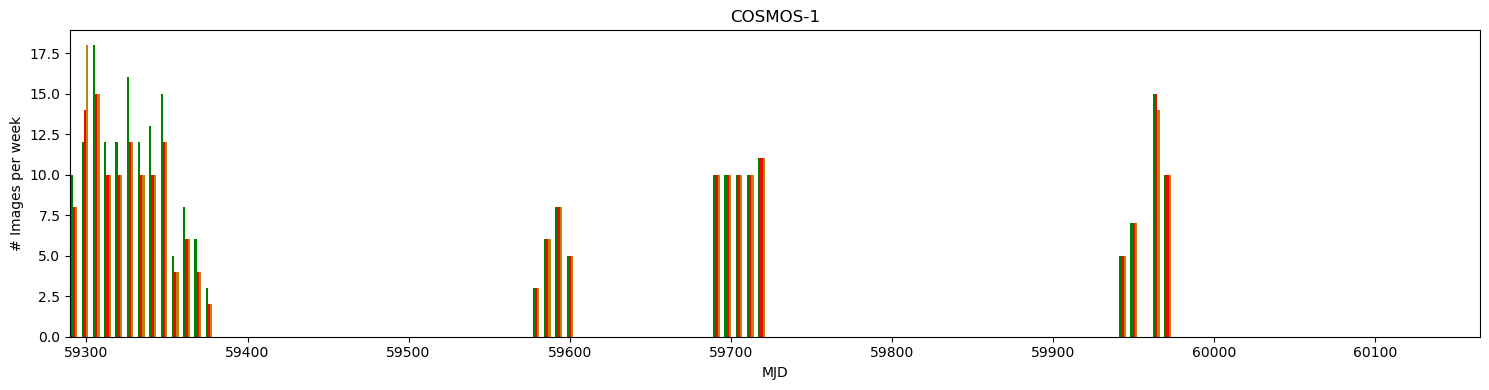

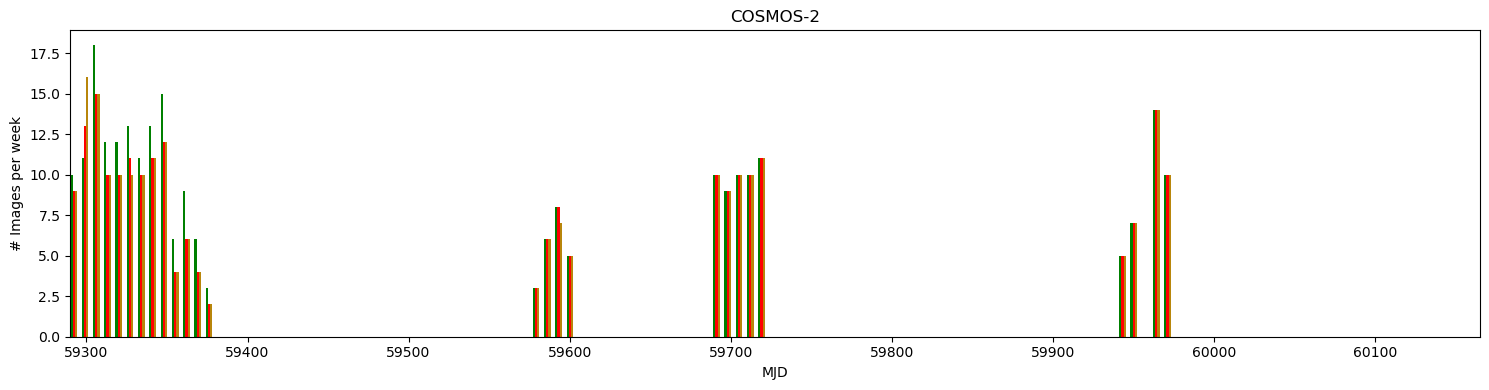

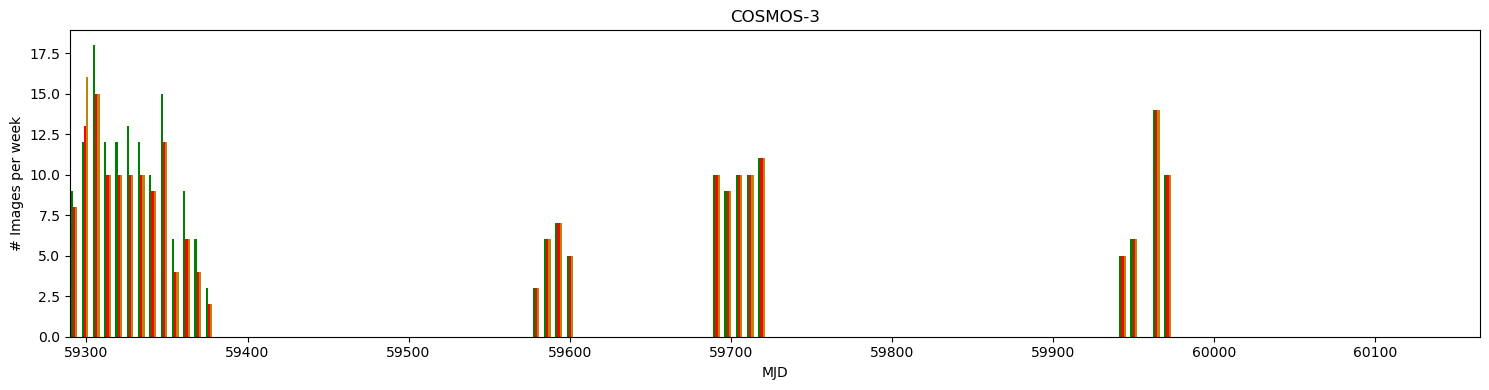

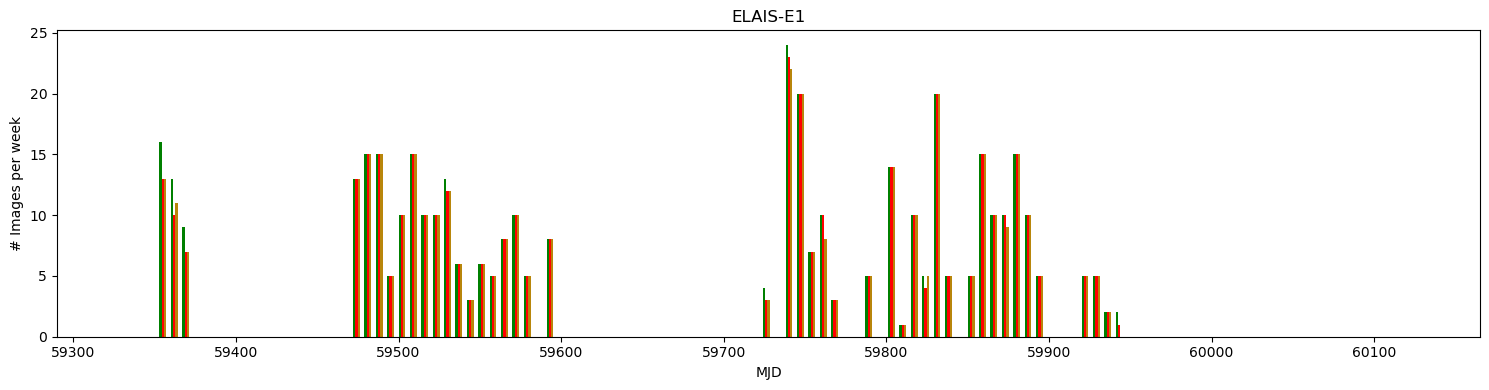

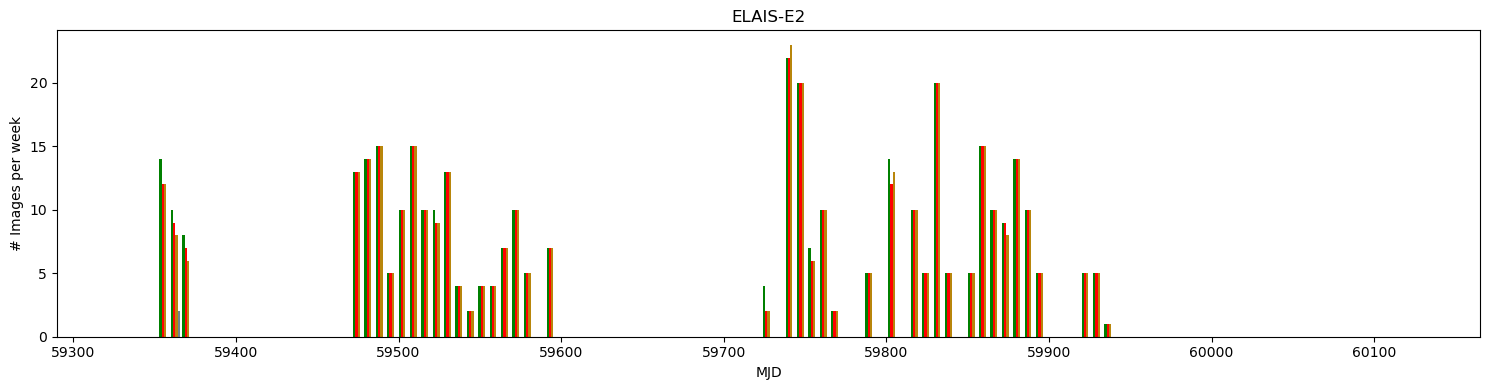

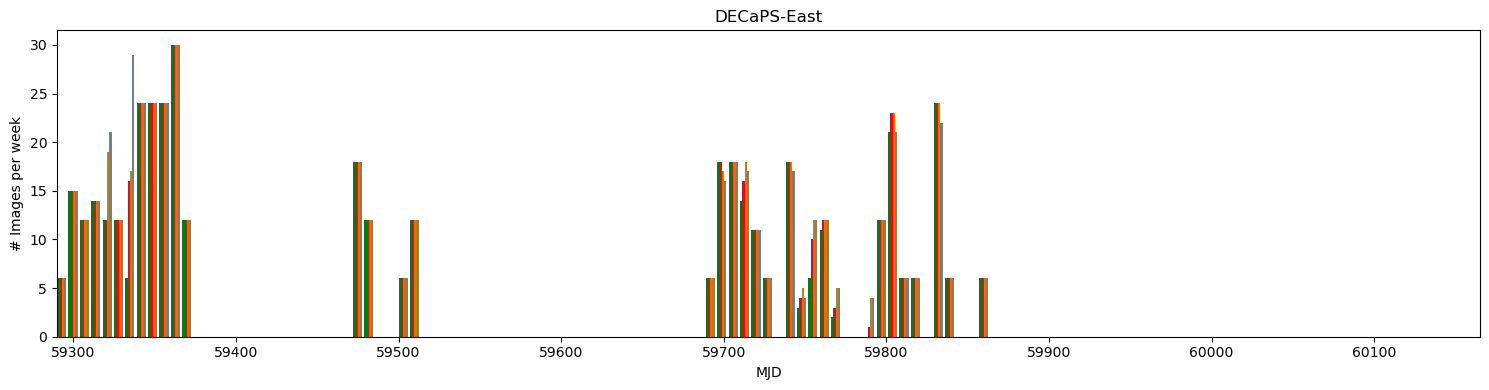

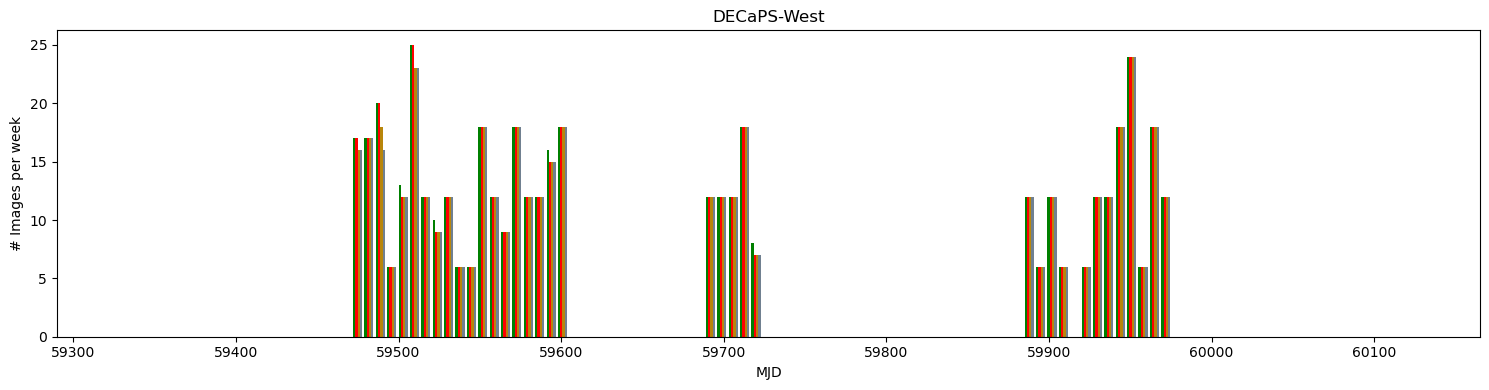

In [8]:
wid = 7. / 5.
for field, df in dfs.items():
    fig = pyplot.figure( figsize=(15, 4), tight_layout=True )
    ax = fig.add_subplot( 1, 1, 1 )
    ax.set_title( field )
    ax.set_xlim( t0, t1 )
    ax.set_xlabel( 'MJD' )
    ax.set_ylabel( '# Images per week' ) 
    off = 0.
    for filt, col in zip( ( 'g', 'r', 'i', 'z' ), ( 'green', 'red', 'darkgoldenrod', 'slategray' ) ):
        subdf = df[ df['filter'] == filt ]
        ax.bar( subdf.mjdleft+off, subdf.nexp, wid, align='edge', color=col )
        off += wid
    fig.show()
                          